# Customer Churn Prediction
Filzahanti Nuha Ramadhani

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer, Normalizer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix, f1_score, recall_score, precision_score
from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from tabulate import tabulate

- The dataset is from <a href='https://www.kaggle.com/datasets/blastchar/telco-customer-churn'>Telco Customer Churn Dataset</a>. 
- There are 21 columns: customerID, gender, SeniorCitizen, Partner, Dependents, tenure, PhoneService, MultipleLines, InternetService, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies, Contract, PaperlessBilling, PaymentMethod,  MonthlyCharges, TotalCharges, and Churn.
- The purpose of this project is to extract insights from Telco Customer Churn Dataset.

## Load Dataset

In [2]:
df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


## Data Preprocessing

### Data Cleaning

Convert white spaces in column 'TotalCharges' with 0 and transform its type to numeric

In [4]:
df['TotalCharges']=df['TotalCharges'].replace(' ', 0)
df['TotalCharges']=pd.to_numeric(df['TotalCharges'])

Check if there are missing values and duplicated rows.

In [5]:
df.isna().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [6]:
df.duplicated(subset='customerID').sum()

0

There are no missing values and duplicated rows.

## Data Exploration
Detailed Exploratory Data Analysis can be found here <a href='https://github.com/filzahanti/Data-Science-Bootcamp-Projects/blob/main/Exploratory%20Data%20Analysis/Exploratory%20Data%20Analysis%20on%20Telco%20Customer%20Churn%20Dataset.ipynb'>Exploratory Data Analysis on Telco Customer Churn</a>

Summary statistics of numerical features

In [7]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692,2279.734304
std,0.368612,24.559481,30.090047,2266.794470
min,0.000000,0.000000,18.250000,0.000000
25%,0.000000,9.000000,35.500000,398.550000
50%,0.000000,29.000000,70.350000,1394.550000
75%,0.000000,55.000000,89.850000,3786.600000
max,1.000000,72.000000,118.750000,8684.800000


- There is a customer who just started using Telco.

See the unique values in all columns in df

In [8]:
for col in df:
    print (col, ':', df[col].unique())

customerID : ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
gender : ['Female' 'Male']
SeniorCitizen : [0 1]
Partner : ['Yes' 'No']
Dependents : ['No' 'Yes']
tenure : [ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26  0
 39]
PhoneService : ['No' 'Yes']
MultipleLines : ['No phone service' 'No' 'Yes']
InternetService : ['DSL' 'Fiber optic' 'No']
OnlineSecurity : ['No' 'Yes' 'No internet service']
OnlineBackup : ['Yes' 'No' 'No internet service']
DeviceProtection : ['No' 'Yes' 'No internet service']
TechSupport : ['No' 'Yes' 'No internet service']
StreamingTV : ['No' 'Yes' 'No internet service']
StreamingMovies : ['No' 'Yes' 'No internet service']
Contract : ['Month-to-month' 'One year' 'Two year']
PaperlessBilling : ['Yes' 'No']
PaymentMethod : ['Electronic check' 'Mailed check' 'Bank tr

- Partner, gender, Dependents, PhoneService, MultipleLines, InternetService, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies, Contract, PaperlessBilling, PaymentMethod, and Churn are categorical features that are not numeric.
- We will encode them so that they could be used for machine learning models.

Distribution of the target variable

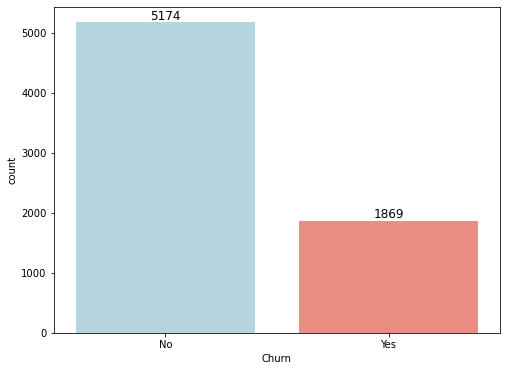

In [54]:
#Adjust the figure size
plt.figure(figsize=(8,6))
ax = sns.countplot(data=df, x='Churn', palette=['lightblue','salmon'])
for i in ax.containers:
    ax.bar_label(i, fontsize=12)

- The number of churned customers is 26.5% of all customers.
- The data is imbalanced.

Distributions of numerical features

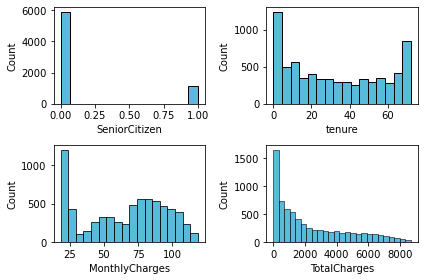

In [10]:
num = df.select_dtypes([np.number])
numericals = num.columns
for i in range(0,len(numericals)):
    plt.subplot(2, len(numericals)//2, i+1)
    sns.histplot(x=df[numericals[i]], color='#20A4CD')
    plt.xlabel(numericals[i])
    plt.tight_layout()

- The tenure distribution appears to be a bimodal distribution. The main peak is at around 1 and the lower peak is at around 70. 
- The monthly charges distribution is a trimodal distribution. The main peak is at around 18, the second peak is at around 80, and the third peak is at around 51.
- The total charges distribution is right skewed.
- Senior citizen has 2 unique values, 1 and 0. Most customers are not senior citizen.

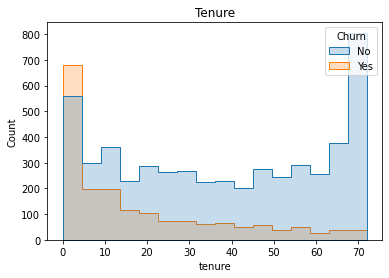

In [45]:
sns.histplot(data=df, x='tenure', hue='Churn', element='step')
plt.title('Tenure')
plt.show()

- The tenure distribution of churned customers is right skewed, most of them had low tenures.
- The number of existing customers who have high tenure is bigger than churned customers.

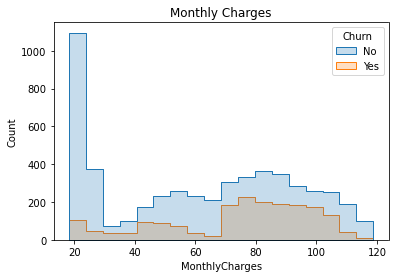

In [47]:
sns.histplot(data=df, x='MonthlyCharges', hue='Churn', element='step')
plt.title('Monthly Charges')
plt.show()

- Customers who left tend to have high monthly charges.
- Many customers with small monthly charges are existing customers. 

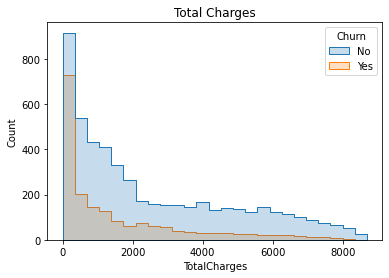

In [48]:
sns.histplot(data=df, x='TotalCharges', hue='Churn', element='step')
plt.title('Total Charges')
plt.show()

- Many existing and churned customers have small total charges.

## Feature Engineering

Replace No internet service and No phone service with No

In [11]:
df = df.replace(['No internet service','No phone service'],'No')

### One-Hot Encoding

In [12]:
cols = ['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 
        'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 
        'PaymentMethod', 'Partner', 'gender', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Contract', 'Churn']
df1 = pd.get_dummies(df, columns=cols, drop_first=True, dtype=int)

In [13]:
df1.columns

Index(['customerID', 'SeniorCitizen', 'tenure', 'MonthlyCharges',
       'TotalCharges', 'MultipleLines_Yes', 'InternetService_Fiber optic',
       'InternetService_No', 'OnlineSecurity_Yes', 'OnlineBackup_Yes',
       'DeviceProtection_Yes', 'TechSupport_Yes', 'StreamingTV_Yes',
       'StreamingMovies_Yes', 'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check',
       'Partner_Yes', 'gender_Male', 'Dependents_Yes', 'PhoneService_Yes',
       'PaperlessBilling_Yes', 'Contract_One year', 'Contract_Two year',
       'Churn_Yes'],
      dtype='object')

## Data Splitting

In [14]:
#Split target variables and other features
X = df1.drop(['Churn_Yes', 'customerID'], axis=1)
y= df1['Churn_Yes']
#Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## XGBoost, Logistic Regression, Random Forest, and LightGBM
In this project, we want to minimize the number of false negatives (churned customers predicted as not churned). Hence, we choose Recall to evaluate the models.

In [15]:
#KFold
k = KFold(n_splits=5, shuffle=True, random_state=42)
#SMOTE
oversampling = SMOTE(random_state=42)
#Standardization
standard = StandardScaler()
col_scaler = ColumnTransformer(transformers=[('standard',standard, ['TotalCharges','MonthlyCharges','tenure'])],
                               remainder='passthrough')

### Without applying SMOTE

#### XGBoost

In [16]:
xg = xgb.XGBClassifier(random_state=42)
xgb_pipe = Pipeline([('xgb', xg)])
param_xgb = {'xgb__max_depth':np.arange(1,10),
             'xgb__learning_rate':np.linspace(0,1,30)}
xgb_search = GridSearchCV(xgb_pipe, param_grid=param_xgb, scoring='recall', cv=k, n_jobs=-1)
xgb_search.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('xgb',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric=None,
                                                      gamma=None, gpu_id=None,
                                                      grow_policy=None,
                                                      importance_type=None...
             param_grid={'xgb__learning_rate': array([0.        , 0.03448276, 0.06896552, 0.10344828, 0.13793103,
       0.17241379, 0.20689655, 0.24137931, 0.27586207, 0.31034483,
       0.34482759, 0.37931034, 0.4137931 , 0.44827586, 0.48275862,
       0.51724138, 0.55172414, 0.5862069 , 0.62068966, 0.65517241,
       0.68965517, 0.72413793, 0.75862069, 0.79310345, 0.82758621,
       0.86206897, 0.89655172, 0.93103448, 0.96551724, 1.        ]),
                         'xgb__max_depth': array([1, 2, 3, 4, 5, 6, 7, 8, 9])},
             scoring='recall')

In [17]:
xgb_pred = xgb_search.predict(X_test)

---------------  ----------------------------------------------------------------
Recall Score     0.5495978552278821
Precision Score  0.6655844155844156
Best Params      {'xgb__learning_rate': 0.24137931034482757, 'xgb__max_depth': 5}
---------------  ----------------------------------------------------------------


Text(33.0, 0.5, 'Actual Values')

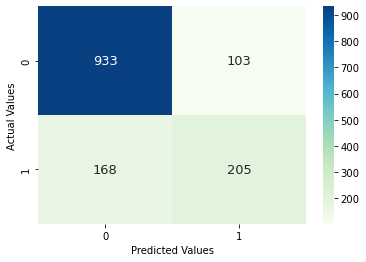

In [18]:
xgb_prec = precision_score(y_test, xgb_pred)
xgb_recall = recall_score(y_test, xgb_pred)
xgb_matrix = confusion_matrix(y_test, xgb_pred)
print(tabulate([['Recall Score',xgb_recall],['Precision Score',xgb_prec],['Best Params', xgb_search.best_params_]]))
#plotting heatmap
sns.heatmap(xgb_matrix, annot=True, cmap='GnBu', fmt='g', annot_kws={'size':13})
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')

#### Logistic Regression
Include feature scaling

In [19]:
lr = LogisticRegression(random_state=42)
lr_pipe = Pipeline([('col_scaler',col_scaler),('lr', lr)])
param_lr = {'lr__C':np.linspace(0,10,50),
           'lr__max_iter':[150,200,400,500]}
lr_search = GridSearchCV(lr_pipe, param_grid=param_lr, scoring='roc_auc', cv=k, n_jobs=-1)
lr_search.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('col_scaler',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('standard',
                                                                         StandardScaler(),
                                                                         ['TotalCharges',
                                                                          'MonthlyCharges',
                                                                          'tenure'])])),
                                       ('lr',
                                        LogisticRegression(random_state=42))]),
             n_jobs=-1,
             param_grid={'lr__C': array([ 0.        ,  0.20408163,  0.40816327,  0.612244...
        4.08163265,  4.28571429,  4.48979592,  4.69387755,  4.89795918,
        5.10204082,  5.30612245,  5.51020408,  5.71428571,  5.91836735,
        6.12244898,  6.32653061,  6.53061224,  6.73469388,  6.93877551,
        7.14285714,  7.34693878,  7.55102041,  7.75510204,  7.95918367,
        8.16326531,  8.36734694,  8.57142857,  8.7755102 ,  8.97959184,
        9.18367347,  9.3877551 ,  9.59183673,  9.79591837, 10.        ]),
                         'lr__max_iter': [150, 200, 400, 500]},
             scoring='roc_auc')

In [20]:
lr_pred = lr_search.predict(X_test)

---------------  -------------------------------------------------
Recall Score     0.5924932975871313
Precision Score  0.6820987654320988
Best params      {'lr__C': 9.795918367346939, 'lr__max_iter': 150}
---------------  -------------------------------------------------


Text(33.0, 0.5, 'Actual Values')

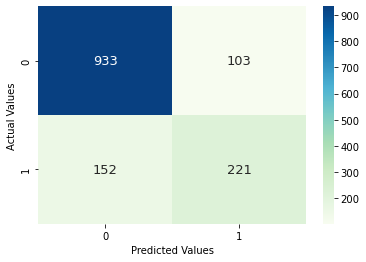

In [21]:
lr_prec = precision_score(y_test, lr_pred)
lr_recall = recall_score(y_test, lr_pred)
lr_matrix = confusion_matrix(y_test, lr_pred)
sns.heatmap(lr_matrix, annot=True, cmap='GnBu', fmt='g', annot_kws={'size':13})
print(tabulate([['Recall Score',lr_recall],['Precision Score',lr_prec],['Best params', lr_search.best_params_]]))
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')

#### Random Forest

In [22]:
rf = RandomForestClassifier(random_state=42)
rf_pipe = Pipeline([('rf', rf)])
param_rf = {'rf__criterion': ['gini','entropy','log_loss'], 
            'rf__min_samples_split':np.arange(2,15)}
rf_search = GridSearchCV(rf_pipe, param_grid=param_rf, scoring='f1', cv=k, n_jobs=-1)
rf_search.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('rf',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'rf__criterion': ['gini', 'entropy', 'log_loss'],
                         'rf__min_samples_split': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])},
             scoring='f1')

In [23]:
rf_pred = rf_search.predict(X_test)

---------------  ---------------------------------------------------------
Recall Score     0.4932975871313673
Precision Score  0.6789667896678967
Best params      {'rf__criterion': 'entropy', 'rf__min_samples_split': 13}
---------------  ---------------------------------------------------------


Text(33.0, 0.5, 'Actual Values')

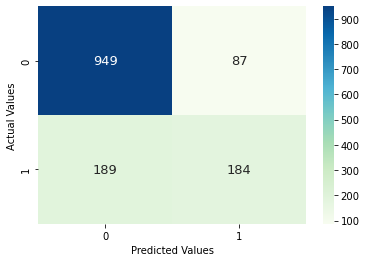

In [24]:
rf_prec = precision_score(y_test, rf_pred)
rf_recall = recall_score(y_test, rf_pred)
rf_matrix = confusion_matrix(y_test, rf_pred)
sns.heatmap(rf_matrix, annot=True, cmap='GnBu', fmt='g', annot_kws={'size':13})
print(tabulate([['Recall Score',rf_recall],['Precision Score',rf_prec],['Best params', rf_search.best_params_]]))
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')

#### LGBM Classifier

In [25]:
lgbm = LGBMClassifier()
lgbm_pipe = Pipeline([('lgbm', lgbm)])
param_lgbm = {'lgbm__n_estimators': [30, 50, 100, 200]}
lgbm_search = GridSearchCV(lgbm_pipe, param_grid=param_lgbm, scoring='f1', cv=k, n_jobs=-1)
lgbm_search.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('lgbm', LGBMClassifier())]), n_jobs=-1,
             param_grid={'lgbm__n_estimators': [30, 50, 100, 200]},
             scoring='f1')

In [26]:
lgbm_pred = lgbm_search.predict(X_test)

---------------  --------------------------
Recall Score     0.5281501340482574
Precision Score  0.6677966101694915
Best params      {'lgbm__n_estimators': 50}
---------------  --------------------------


Text(33.0, 0.5, 'Actual Values')

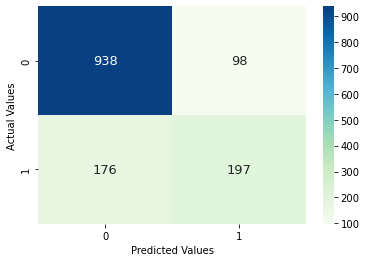

In [27]:
lgbm_recall = recall_score(y_test, lgbm_pred)
lgbm_prec = precision_score(y_test, lgbm_pred)
lgbm_matrix = confusion_matrix(y_test, lgbm_pred)
sns.heatmap(lgbm_matrix, annot=True, cmap='GnBu', fmt='g', annot_kws={'size':13})
print(tabulate([['Recall Score',lgbm_recall],['Precision Score',lgbm_prec],['Best params', lgbm_search.best_params_]]))
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')

### Apply SMOTE

#### XGBoost

In [28]:
xg = xgb.XGBClassifier(random_state=42)
xgb_pipe = Pipeline([('oversampling',oversampling),('xgb', xg)])
param_xgb = {'xgb__max_depth':np.arange(1,10),
             'xgb__learning_rate':np.linspace(0,1,30)}
xgb_search_os = GridSearchCV(xgb_pipe, param_grid=param_xgb, scoring='f1', cv=k, n_jobs=-1)
xgb_search_os.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('oversampling', SMOTE(random_state=42)),
                                       ('xgb',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric=None,
                                                      gamma=None, gpu_id=No...
             param_grid={'xgb__learning_rate': array([0.        , 0.03448276, 0.06896552, 0.10344828, 0.13793103,
       0.17241379, 0.20689655, 0.24137931, 0.27586207, 0.31034483,
       0.34482759, 0.37931034, 0.4137931 , 0.44827586, 0.48275862,
       0.51724138, 0.55172414, 0.5862069 , 0.62068966, 0.65517241,
       0.68965517, 0.72413793, 0.75862069, 0.79310345, 0.82758621,
       0.86206897, 0.89655172, 0.93103448, 0.96551724, 1.        ]),
                         'xgb__max_depth': array([1, 2, 3, 4, 5, 6, 7, 8, 9])},
             scoring='f1')

In [29]:
xgb_pred_os = xgb_search_os.predict(X_test)

---------------  ----------------------------------------------------------------
Recall Score     0.8096514745308311
Precision Score  0.5451263537906137
Best Params      {'xgb__learning_rate': 0.10344827586206896, 'xgb__max_depth': 1}
---------------  ----------------------------------------------------------------


Text(33.0, 0.5, 'Actual Values')

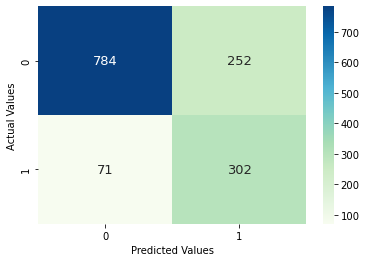

In [30]:
xgb_recall_os = recall_score(y_test, xgb_pred_os)
xgb_prec_os = precision_score(y_test, xgb_pred_os)
xgb_matrix_os = confusion_matrix(y_test, xgb_pred_os)
sns.heatmap(xgb_matrix_os, annot=True, cmap='GnBu', fmt='g', annot_kws={'size':13})
print(tabulate([['Recall Score',xgb_recall_os],['Precision Score',xgb_prec_os],['Best Params', xgb_search_os.best_params_]]))
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')

#### Logistic Regression
Include feature scaling

In [31]:
lr = LogisticRegression(random_state=42)
lr_pipe = Pipeline([('col_scaler',col_scaler),('oversampling',oversampling),('lr', lr)])
param_lr = {'lr__C':np.linspace(0,10,50),
           'lr__max_iter':[150,200,400,500]}
lr_search_os = GridSearchCV(lr_pipe, param_grid=param_lr, scoring='roc_auc', cv=k, n_jobs=-1)
lr_search_os.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('col_scaler',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('standard',
                                                                         StandardScaler(),
                                                                         ['TotalCharges',
                                                                          'MonthlyCharges',
                                                                          'tenure'])])),
                                       ('oversampling', SMOTE(random_state=42)),
                                       ('lr',
                                        LogisticRegression(random_state=42))]),
             n_jobs=-1,
             param_grid={'lr__C':...
        4.08163265,  4.28571429,  4.48979592,  4.69387755,  4.89795918,
        5.10204082,  5.30612245,  5.51020408,  5.71428571,  5.91836735,
        6.12244898,  6.32653061,  6.53061224,  6.73469388,  6.93877551,
        7.14285714,  7.34693878,  7.55102041,  7.75510204,  7.95918367,
        8.16326531,  8.36734694,  8.57142857,  8.7755102 ,  8.97959184,
        9.18367347,  9.3877551 ,  9.59183673,  9.79591837, 10.        ]),
                         'lr__max_iter': [150, 200, 400, 500]},
             scoring='roc_auc')

In [32]:
lr_pred_os = lr_search_os.predict(X_test)

---------------  -------------------------------------------------
Recall Score     0.8310991957104558
Precision Score  0.5218855218855218
Best params      {'lr__C': 9.795918367346939, 'lr__max_iter': 150}
---------------  -------------------------------------------------


Text(33.0, 0.5, 'Actual Values')

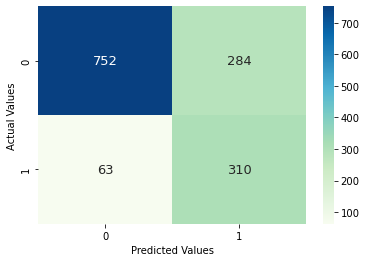

In [33]:
lr_recall_os = recall_score(y_test, lr_pred_os)
lr_prec_os = precision_score(y_test, lr_pred_os)
lr_matrix_os = confusion_matrix(y_test, lr_pred_os)
sns.heatmap(lr_matrix_os, annot=True, cmap='GnBu', fmt='g', annot_kws={'size':13})
print(tabulate([['Recall Score',lr_recall_os],['Precision Score',lr_prec_os],['Best params', lr_search_os.best_params_]]))
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')

#### Random Forest

In [34]:
rf = RandomForestClassifier(random_state=42)
rf_pipe = Pipeline([('oversampling',oversampling),('rf', rf)])
param_rf = {'rf__criterion': ['gini','entropy','log_loss'], 
            'rf__min_samples_split':np.arange(2,15)}
rf_search_os = GridSearchCV(rf_pipe, param_grid=param_rf, scoring='f1', cv=k, n_jobs=-1)
rf_search_os.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('oversampling', SMOTE(random_state=42)),
                                       ('rf',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'rf__criterion': ['gini', 'entropy', 'log_loss'],
                         'rf__min_samples_split': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])},
             scoring='f1')

In [35]:
rf_pred_os = rf_search_os.predict(X_test)

---------------  ------------------------------------------------------
Recall Score     0.6407506702412868
Precision Score  0.5800970873786407
Best params      {'rf__criterion': 'gini', 'rf__min_samples_split': 14}
---------------  ------------------------------------------------------


Text(33.0, 0.5, 'Actual Values')

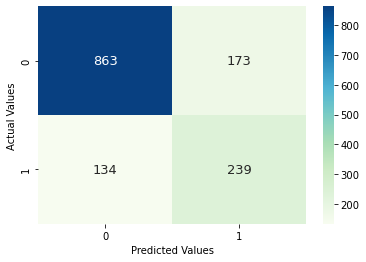

In [36]:
rf_recall_os = recall_score(y_test, rf_pred_os)
rf_prec_os = precision_score(y_test, rf_pred_os)
rf_matrix_os = confusion_matrix(y_test, rf_pred_os)
sns.heatmap(rf_matrix_os, annot=True, cmap='GnBu', fmt='g', annot_kws={'size':13})
print(tabulate([['Recall Score',rf_recall_os],['Precision Score',rf_prec_os],['Best params', rf_search_os.best_params_]]))
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')

#### LGBM Classifier

In [37]:
lgbm = LGBMClassifier()
lgbm_pipe = Pipeline([('oversampling',oversampling),('lgbm', lgbm)])
param_lgbm = {'lgbm__n_estimators': [30, 50, 100, 200]}
lgbm_search_os = GridSearchCV(lgbm_pipe, param_grid=param_lgbm, scoring='f1', cv=k, n_jobs=-1)
lgbm_search_os.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('oversampling', SMOTE(random_state=42)),
                                       ('lgbm', LGBMClassifier())]),
             n_jobs=-1, param_grid={'lgbm__n_estimators': [30, 50, 100, 200]},
             scoring='f1')

In [38]:
lgbm_pred_os = lgbm_search_os.predict(X_test)

---------------  --------------------------
Recall Score     0.6809651474530831
Precision Score  0.5772727272727273
Best params      {'lgbm__n_estimators': 30}
---------------  --------------------------


Text(33.0, 0.5, 'Actual Values')

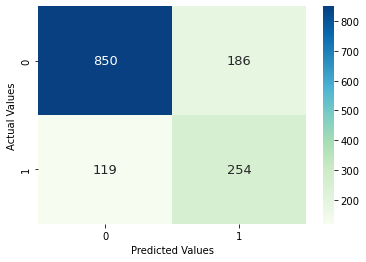

In [39]:
lgbm_recall_os = recall_score(y_test, lgbm_pred_os)
lgbm_prec_os = precision_score(y_test, lgbm_pred_os)
lgbm_matrix_os = confusion_matrix(y_test, lgbm_pred_os)
sns.heatmap(lgbm_matrix_os, annot=True, cmap='GnBu', fmt='g', annot_kws={'size':13})
print(tabulate([['Recall Score',lgbm_recall_os],['Precision Score',lgbm_prec_os],['Best params', lgbm_search_os.best_params_]]))
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')

### Evaluation

In [40]:
perf = [[xgb_recall, lr_recall, rf_recall, lgbm_recall],[xgb_recall_os, lr_recall_os, rf_recall_os, lgbm_recall_os]]
recall_model = pd.DataFrame(perf, columns=['xgb','logreg','rf','lgbm'])

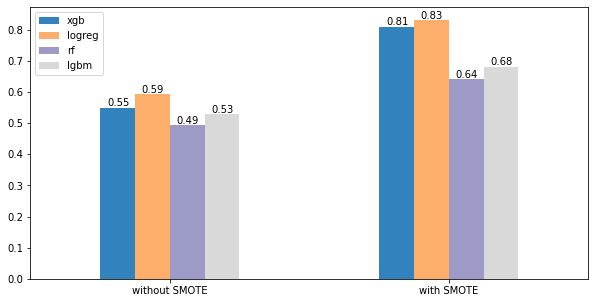

In [41]:
ax = recall_model.plot(kind='bar', colormap='tab20c',figsize=(10,5))
ax.set_xticklabels(['without SMOTE', 'with SMOTE'], rotation=0)
for i in ax.patches:
    ax.annotate(str(round(i.get_height(),2)), (i.get_x()+0.025, i.get_height()+0.005))

- Recall score of models with SMOTE are higher than models without SMOTE
- The best model is Logistic Regression with SMOTE. It achieved the highest recall score, 0.83.
- This model correctly predicted 83% churned customers.